In [55]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import ray
from ray import tune
from ray.tune.schedulers import ASHAScheduler
import shutil
import matplotlib.pyplot as plt
import pandas as pd

from DataObjects import DataLoader
from Architectures.SimpleCNN import SimpleCNN
from Architectures.OptimalCNN import OptimalCNN
from Architectures.StochasticDepthCNN import StochasticDepthCNN

from typing import Optional, Tuple

from utils import save_model, load_model


In [56]:
def train_model(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader,
                num_epochs: int = 10, lr: float = 0.001,
                device: torch.device = None) -> None:
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion: nn.Module = nn.CrossEntropyLoss()
    optimizer: torch.optim.Optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        train_loss: float = 0.0
        train_correct: int = 0
        total_train: int = 0

        for batch in train_loader:
            inputs = batch.data.to(device)
            labels = batch.labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += torch.sum(preds == labels).item()
            total_train += labels.size(0)

        avg_train_loss = train_loss / total_train
        train_acc = train_correct / total_train

        model.eval()
        val_loss: float = 0.0
        val_correct: int = 0
        total_val: int = 0

        with torch.no_grad():
            for batch in val_loader:
                inputs = batch.data.to(device)
                labels = batch.labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += torch.sum(preds == labels).item()
                total_val += labels.size(0)

        avg_val_loss = val_loss / total_val
        val_acc = val_correct / total_val

        print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {avg_train_loss:.4f}, Train acc: {train_acc:.4f} | Val loss: {avg_val_loss:.4f}, Val acc: {val_acc:.4f}")

def infer(model: nn.Module, data_loader: DataLoader,
          device: torch.device = None) -> list:
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    predictions: list = []

    with torch.no_grad():
        for batch in data_loader:
            inputs = batch.data.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().tolist())

    return predictions


def evaluate(model: nn.Module,
             test_loader: Optional[DataLoader] = None,
             device: Optional[torch.device] = None) -> Tuple[float, float]:

    if test_loader is None:
        test_dir = os.path.join("Data", "Data_converted", "test")
        test_loader = DataLoader(test_dir, batch_size=64, shuffle=True)

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)
    criterion = nn.CrossEntropyLoss()
    model.eval()

    test_loss = 0.0
    test_correct = 0
    total_test = 0

    with torch.no_grad():
        for batch in test_loader:
            inputs = batch.data.to(device)
            labels = batch.labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            test_correct += torch.sum(preds == labels).item()
            total_test += labels.size(0)

    avg_test_loss = test_loss / total_test
    test_acc = test_correct / total_test

    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
    return avg_test_loss, test_acc

In [57]:
def train_model_tune(config, num_epochs=10, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_loader = DataLoader(config["train_dir"], batch_size=config["batch_size"], shuffle=True, max_per_class=150)
    val_loader = DataLoader(config["val_dir"], batch_size=config["batch_size"], shuffle=False, max_per_class=150)

    # Instantiate the model dynamically
    model = OptimalCNN(num_classes=10).to(device)

    # Loss function & Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config["lr"])

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        total_train = 0

        for batch in train_loader:
            inputs = batch.data.to(device)
            labels = batch.labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += torch.sum(preds == labels).item()
            total_train += labels.size(0)

        avg_train_loss = train_loss / total_train
        train_acc = train_correct / total_train

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        total_val = 0

        with torch.no_grad():
            for batch in val_loader:
                inputs = batch.data.to(device)
                labels = batch.labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += torch.sum(preds == labels).item()
                total_val += labels.size(0)

        avg_val_loss = val_loss / total_val
        val_acc = val_correct / total_val

        # Log to Ray Tune
        tune.report({"accuracy": val_acc, "loss": avg_val_loss })

In [58]:
@ray.remote
def setup_worker():
    """Ensure each Ray worker has access to the dataset."""
    worker_data_path = os.path.join(os.getcwd(), "worker_data")

    if not os.path.exists(worker_data_path):
        os.makedirs(worker_data_path)

    # Copy dataset if it doesn’t already exist
    source_data_path = os.path.abspath("Data/Data_converted")
    if not os.path.exists(os.path.join(worker_data_path, "Data_converted")):
        shutil.copytree(source_data_path, os.path.join(worker_data_path, "Data_converted"))

    return f"Worker setup complete: {worker_data_path}"

In [59]:
config = {
    "lr": tune.loguniform(1e-4, 1e-1),
    "batch_size": tune.choice([8, 16, 32, 64]),
    "train_dir": os.path.abspath("Data/Data_converted/train"),
    "val_dir": os.path.abspath("Data/Data_converted/valid")
}
scheduler = ASHAScheduler(metric="accuracy",
                          mode="max",
                          max_t=10,
                          grace_period=2,
                          reduction_factor=2)

In [60]:
test_dir = os.path.abspath("Data/Data_converted/test")
test_loader = DataLoader(test_dir, batch_size=64, shuffle=False)

In [61]:
ray.init(ignore_reinit_error=True)
# Run this before training
ray.get(setup_worker.remote())
# Launch hyperparameter search
tuner = tune.run(
    tune.with_parameters(train_model_tune),
    config=config,
    num_samples=10,  # Number of trials
    scheduler=scheduler
)

# Get the best configuration
best_trial = tuner.get_best_trial("accuracy", mode="max", scope="all")
best_config = best_trial.config
print("Best hyperparameters:", best_config)

2025-03-24 11:14:33,395	INFO worker.py:1684 -- Calling ray.init() again after it has already been called.
2025-03-24 11:14:33,399	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


2025-03-24 11:19:37,106	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/piotr/ray_results/train_model_tune_2025-03-24_11-14-33' in 0.0040s.
2025-03-24 11:19:37,111	INFO tune.py:1041 -- Total run time: 303.71 seconds (303.70 seconds for the tuning loop).


Best hyperparameters: {'lr': 0.0006542236215741476, 'batch_size': 8, 'train_dir': '/home/piotr/PycharmProjects/dl_project1/DeepLearning/Project_I/Data/Data_converted/train', 'val_dir': '/home/piotr/PycharmProjects/dl_project1/DeepLearning/Project_I/Data/Data_converted/valid'}


In [62]:
best_model = OptimalCNN(num_classes=10)

# Setup directories and DataLoaders
train_dir = os.path.abspath("Data/Data_converted/train")
val_dir = os.path.abspath("Data/Data_converted/valid")

train_loader = DataLoader(train_dir, batch_size=best_config["batch_size"], shuffle=True, max_per_class=150)
val_loader = DataLoader(val_dir, batch_size=best_config["batch_size"], shuffle=False, max_per_class=150)

train_model(best_model, train_loader, val_loader, num_epochs=10, lr=best_config["lr"])

Epoch 1/10 - Train loss: 2.1418, Train acc: 0.2433 | Val loss: 2.3772, Val acc: 0.2353
Epoch 2/10 - Train loss: 1.8283, Train acc: 0.3580 | Val loss: 1.8983, Val acc: 0.3540
Epoch 3/10 - Train loss: 1.6446, Train acc: 0.3940 | Val loss: 1.5763, Val acc: 0.4413
Epoch 4/10 - Train loss: 1.4491, Train acc: 0.5007 | Val loss: 1.6895, Val acc: 0.3860
Epoch 5/10 - Train loss: 1.2537, Train acc: 0.5540 | Val loss: 1.4706, Val acc: 0.4893
Epoch 6/10 - Train loss: 1.1034, Train acc: 0.6147 | Val loss: 1.7092, Val acc: 0.4473
Epoch 7/10 - Train loss: 0.9129, Train acc: 0.6933 | Val loss: 1.4690, Val acc: 0.4880
Epoch 8/10 - Train loss: 0.7696, Train acc: 0.7340 | Val loss: 1.7449, Val acc: 0.4500
Epoch 9/10 - Train loss: 0.5782, Train acc: 0.8127 | Val loss: 1.6390, Val acc: 0.4707
Epoch 10/10 - Train loss: 0.4421, Train acc: 0.8640 | Val loss: 1.5860, Val acc: 0.5213


In [63]:
evaluate(best_model, test_loader)

Test Loss: 2.1958, Test Accuracy: 0.4059


(2.1958315886603463, 0.4059)

In [64]:
best_batch = best_config.get('batch_size')
best_lr = best_config.get('lr')

config_batch = {
    "lr": tune.loguniform(1e-4, 1e-1),
    "batch_size": best_batch,
    "train_dir": os.path.abspath("Data/Data_converted/train"),
    "val_dir": os.path.abspath("Data/Data_converted/valid")
}

config_lr = {
    "lr": best_lr,
    "batch_size": tune.choice([8, 16, 32, 64]),
    "train_dir": os.path.abspath("Data/Data_converted/train"),
    "val_dir": os.path.abspath("Data/Data_converted/valid")
}

2025-03-24 11:20:03,981	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


2025-03-24 11:24:47,729	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/piotr/ray_results/train_model_tune_2025-03-24_11-20-03' in 0.0047s.
2025-03-24 11:24:47,734	INFO tune.py:1041 -- Total run time: 283.75 seconds (283.74 seconds for the tuning loop).


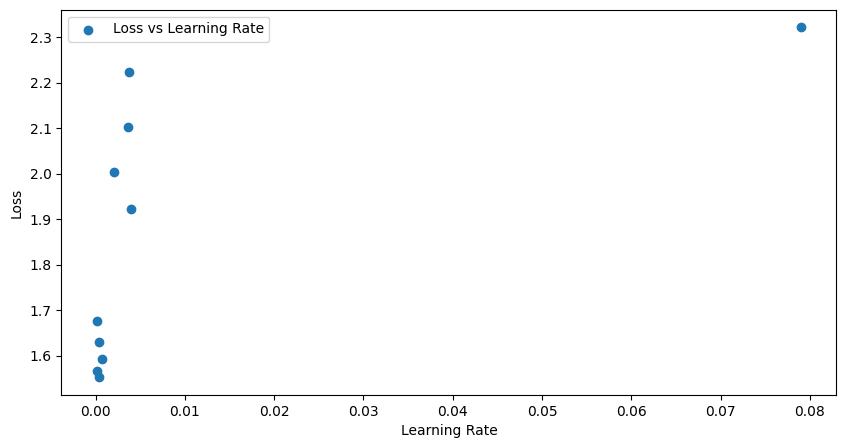

In [65]:
tuner = tune.run(
    tune.with_parameters(train_model_tune),
    config=config_batch,
    num_samples=10,  # Number of trials
    scheduler=scheduler
)

df = tuner.results_df
plt.figure(figsize=(10, 5))
plt.scatter(df["config/lr"], df["loss"], label="Loss vs Learning Rate")
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [66]:
tuner = tune.run(
    tune.with_parameters(train_model_tune),
    config=config_lr,
    num_samples=10,  # Number of trials
    scheduler=scheduler
)

df = tuner.results_df
plt.figure(figsize=(10, 5))
plt.scatter(df["config/batch_size"], df["loss"], label="Loss vs Batch Size")
plt.xlabel("Batch Size")
plt.ylabel("Loss")
plt.legend()
plt.show()

2025-03-24 11:24:47,851	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


2025-03-24 11:24:50,267	ERROR tune_controller.py:1331 -- Trial task failed for trial train_model_tune_365d5_00000
Traceback (most recent call last):
  File "/home/piotr/PycharmProjects/dl_project1/DeepLearning/Project_I/.venv/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/piotr/PycharmProjects/dl_project1/DeepLearning/Project_I/.venv/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/piotr/PycharmProjects/dl_project1/DeepLearning/Project_I/.venv/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/piotr/PycharmProjects/dl_project1/DeepLearning/Project_I/.venv/lib/python3.10/site-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
  File "/home/

2025-03-24 11:24:50,333	ERROR tune_controller.py:1331 -- Trial task failed for trial train_model_tune_365d5_00003
Traceback (most recent call last):
  File "/home/piotr/PycharmProjects/dl_project1/DeepLearning/Project_I/.venv/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/piotr/PycharmProjects/dl_project1/DeepLearning/Project_I/.venv/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/piotr/PycharmProjects/dl_project1/DeepLearning/Project_I/.venv/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/piotr/PycharmProjects/dl_project1/DeepLearning/Project_I/.venv/lib/python3.10/site-packages/ray/_private/worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
  File "/home/

TuneError: ('Trials did not complete', [train_model_tune_365d5_00000, train_model_tune_365d5_00001, train_model_tune_365d5_00002, train_model_tune_365d5_00003, train_model_tune_365d5_00004, train_model_tune_365d5_00005, train_model_tune_365d5_00006, train_model_tune_365d5_00007, train_model_tune_365d5_00008, train_model_tune_365d5_00009])